In [23]:
import cv2
import time
import csv
import datetime
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Image, display
cap = cv2.VideoCapture(2) # use 0 if you only have front facing camera

In [24]:
ret, frame = cap.read() #read one frame

In [67]:
Ntime = 200
top = 500
bottom = 700
stop = 1000
start = 1750
Nslices = 10
height = bottom-top

def getslice(frame,i):
    loc = start + (stop-start)//(Nslices-1)*i
    return np.average(frame[top:bottom,loc],axis=-1)

def getvalue(frame,i):
    loc = start + (stop-start)//(Nslices-1)*i
    return np.average(frame[top:bottom,loc])

ret, frame = cap.read() 
baselines = np.zeros((Nslices))
for i in range(Nslices):
    baselines[i] = getvalue(frame,i)

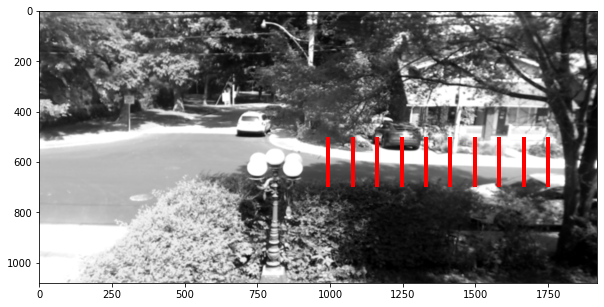

In [68]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.imshow(np.average(frame,axis=-1), interpolation = 'bicubic', cmap="gray",aspect = "auto")
for i in range(Nslices):
    loc = start + (stop-start)//(Nslices-1)*i
    ax.vlines(loc,ymin=top,ymax=bottom,color="red",lw=4)

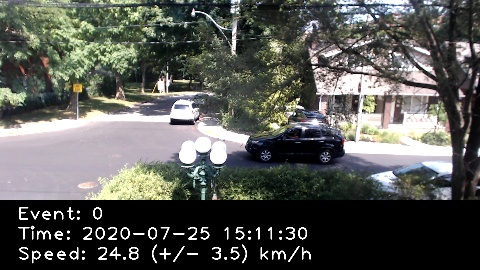

KeyboardInterrupt: 

In [69]:
inprog = 0
threshhold = 20
avg_N = 0
event_N = 0
timesactive = np.zeros((Nslices))
avg = np.zeros((Nslices))
# need to adjust this for calibration (in m)
totallength = 7.59
length_slice = totallength/(Nslices-1)


with open('data/log.csv','w', newline='') as logfile:
    writer = csv.writer(logfile)
    while True:
        ret, frame = cap.read()
        
        while inprog<Nslices:
            cv = abs(baselines[inprog]-getvalue(frame,inprog))
            if cv > threshhold:
                timesactive[inprog] = time.time()
                inprog += 1
            else:
                break
                
        if inprog==Nslices:
            durations = timesactive[1:]-timesactive[:-1]
            speeds = 3.6*length_slice/durations
            speed_avg = np.average(speeds)
            speed_std = np.std(speeds)
            
            if speed_avg>100: #probably an errot
                inprog = 0
                continue
            
            date = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            
            #//print(event_N, date, speed_avg, speed_std)

            cv2.rectangle(frame,(0,800),(2000,2000), (0,0,0),thickness=-1)
            cv2.putText(frame,"Event: %d "%event_N, (70,880), cv2.FONT_HERSHEY_PLAIN, 5, (255,255,255), 5)
            cv2.putText(frame,"Time: " +date, (70,960), cv2.FONT_HERSHEY_PLAIN, 5, (255,255,255), 5)
            cv2.putText(frame,"Speed: %.1f (+/- %.1f) km/h"%(speed_avg,speed_std), (70,1040), cv2.FONT_HERSHEY_PLAIN, 5, (255,255,255), 5)
            small = cv2.resize(frame, (0,0), fx=0.25, fy=0.25) 
            _,ret = cv2.imencode('.jpg', small) 
            cv2.imwrite("data/image_%05d.jpg"%event_N, small) 
            i = Image(data=ret)
            display(i)

            writer.writerow([event_N,date,speed_avg,speed_std])
            logfile.flush()                
            event_N += 1
            
            
            inprog = 0
            continue
            
        if inprog!=0:
            if time.time()-timesactive[0]>2:
                inprog = 0
            continue
        if inprog==0:
            for i in range(Nslices):
                avg[i] += getvalue(frame,i)
            avg_N += 1
            if avg_N == 20:
                baselines = avg/avg_N
                avg_N = 0
                avg = np.zeros((Nslices))
                

            
            